In [56]:
import scipy as sp
from scipy import linalg 
import pylab as plt


In [57]:
n_snps=10000
n_ind=10000

In [58]:
#With LD
x = sp.zeros((n_snps,n_ind))
x[0] = sp.randn(n_ind)
rand_signs = sp.sign(sp.randn(n_snps))
for i in range(1,n_snps):
    conseq_r2=sp.sqrt(sp.rand())
    x[i]=sp.sqrt(conseq_r2)*rand_signs[i]*x[i-1]+sp.randn(n_ind)*sp.sqrt(1-conseq_r2)
    

In [59]:
#LD and scaled genotypes
x = (x.T-sp.mean(x,axis=1)).T
x = (x.T/sp.std(x,axis=1)).T
xx = x@x.T
D = xx/sp.diag(xx)
D.shape
D

array([[ 1.00000000e+00, -9.64521818e-01, -4.35284943e-01, ...,
        -6.37955570e-03, -9.07027878e-03, -3.24669911e-03],
       [-9.64521818e-01,  1.00000000e+00,  4.46463089e-01, ...,
         7.36056533e-03,  7.96817677e-03,  6.60611501e-04],
       [-4.35284943e-01,  4.46463089e-01,  1.00000000e+00, ...,
         7.14728884e-03,  9.97611429e-03,  1.01578512e-02],
       ...,
       [-6.37955570e-03,  7.36056533e-03,  7.14728884e-03, ...,
         1.00000000e+00, -5.10404252e-01, -3.56977418e-01],
       [-9.07027878e-03,  7.96817677e-03,  9.97611429e-03, ...,
        -5.10404252e-01,  1.00000000e+00,  6.91470893e-01],
       [-3.24669911e-03,  6.60611501e-04,  1.01578512e-02, ...,
        -3.56977418e-01,  6.91470893e-01,  1.00000000e+00]])

In [60]:
#LD scores
ldsc = sp.diag(D@D)
ldsc

array([3.59101877, 3.61270207, 4.79388234, ..., 4.54018735, 3.26513457,
       2.82498262])

In [72]:
#Banded LD 
w=20
D_mask = sp.zeros((n_snps,n_snps))
for i in range(n_snps):
    min_i = max(0,i-w)
    max_i = min(n_snps,i+w)
    D_mask[min_i:max_i,i]=D[min_i:max_i,i]

In [73]:
#Banded LD scores
ldsc_mask = sp.diag(D_mask@D_mask)
ldsc_mask

array([2.58145823, 2.61473141, 3.8097833 , ..., 3.55856686, 2.28709257,
       1.86209771])

In [173]:
#Simulate phenotypes
def sim_phen(x, h2=0.8,n_phen=1000,prior='inf'):
    (n_snps,n_ind) =x.shape
    if prior=='inf':
        betas_true = sp.sqrt(h2/n_snps)*sp.randn(n_phen,n_snps)
    else:
        raise Exception()
    y_g = betas_true@x
    y_e = sp.randn(n_phen,n_ind)
    y = sp.sqrt(h2) *((y_g.T / sp.std(y_g,axis=1)).T) + sp.sqrt(1-h2)*y_e
    #Standardize phenotypes
    y = ((y.T - sp.mean(y,axis=1))/sp.std(y,axis=1)).T
    return {'y': y, 'y_g':y_g, 'y_e':y_e, 'betas_true':betas_true}


In [174]:
sim_phen = sim_phen(x, h2=0.8,n_phen=1000)
y = sim_phen['y']
betas_true = sim_phen['betas_true']

In [175]:
#Perform GWAS
x_train = x[:,:int(n_ind/2)]
y_train = y[:,:int(n_ind/2)]
x_test = x[:,int(n_ind/2):]
y_test = y[:,int(n_ind/2):]
betas = x_train@y_train.T/(n_ind/2)

In [176]:
#Perform "p-value" thresholding
betas_thres = betas.copy()
betas_thres[betas**2<0.001]=0


In [177]:
#LDSC regression on GWAS sum stats
def run_ldsc(bs, ldsc, n_ind):
    (n_snps,n_phen) = bs.shape
    x2 = n_ind*(bs*bs).T
    x_var = sp.vstack((sp.ones((n_snps,)),ldsc))
    xx_i = linalg.inv(x_var@x_var.T)
    h2s = sp.zeros(n_phen)
    intercepts = sp.zeros(n_phen)
    for i in range(n_phen):
        w = (xx_i)@x_var@x2[i,]
        intercepts[i] = w[0]
        h2s[i] = n_snps*w[1]/(n_ind)
    return {'intercepts':intercepts, 'h2s':h2s, 'slope':n_ind*(h2s/n_snps)}




In [178]:
#LDSC with full LD
res = run_ldsc(betas, ldsc, n_ind/2.0)
print (sp.mean(res['intercepts']))
print (sp.mean(res['h2s']))


0.566226872070915
0.811409757321007


In [179]:
#LDSC with full masked LD
banded_res = run_ldsc(betas, ldsc_mask, n_ind/2.0)
print (sp.mean(banded_res['intercepts']))
print (sp.mean(banded_res['h2s']))
print (sp.mean(banded_res['slope']))


0.9713133952819648
0.8112903796786182
0.4056451898393091


-0.1186013776514535
0.8225760085100727
0.41128800425503637


In [181]:
def simp_lin_reg(y, x):
    (n,) = x.shape
    x_var = sp.vstack((sp.ones(n),x))
    xx_i = linalg.inv(x_var@x_var.T)
    w = (xx_i)@x_var@y
    return w


In [190]:
# Cs using GWAS betas
c = sp.diag(betas.T @ D @ betas)
c_mask = sp.diag(betas.T @ D_mask @ betas)

[-3.20913414  1.33110591]


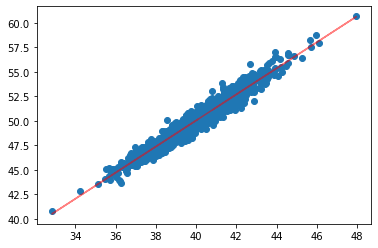

In [191]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)


In [209]:
#LDSC 
ldsc_res = run_ldsc(betas, ldsc_mask, n_ind/2.0)
print (sp.mean(ldsc_res['intercepts']))
print (sp.mean(ldsc_res['h2s']))
print (sp.mean(ldsc_res['slope']))

0.9713133952819648
0.8112903796786182
0.6369028103559514


In [203]:
# Cs using p-val thresholded GWAS betas
c = sp.diag(betas_thres.T @ D @ betas_thres)
c_mask = sp.diag(betas_thres.T @ D_mask @ betas_thres)


[-0.97253473  1.22912071]


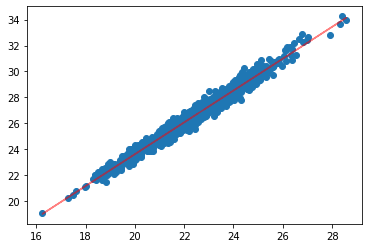

In [204]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)

In [210]:
#LDSC 
banded_res_t = run_ldsc(betas_thres, ldsc_mask, n_ind/2.0)
print (sp.mean(banded_res_t['intercepts']))
print (sp.mean(banded_res_t['h2s']))
print (sp.mean(banded_res_t['slope']))

-0.1186013776514535
0.8225760085100727
0.41128800425503637


In [211]:
# Cs using true betas
c = sp.diag(betas_true @ D @ betas_true.T)
c_mask = sp.diag(betas_true @ D_mask @ betas_true.T)


[0.02049932 0.97440792]


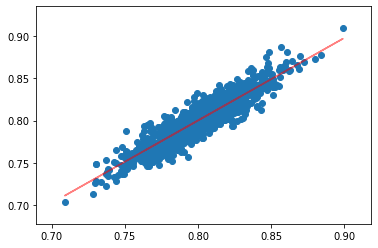

In [212]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)

In [213]:
#LDSC 
ldsc_res = run_ldsc(betas_true.T, ldsc_mask, n_ind)
print (sp.mean(ldsc_res['intercepts']))
print (sp.mean(ldsc_res['h2s']))
print (sp.mean(ldsc_res['slope']))

0.8000724740927331
-3.3859850641876075e-06
-3.385985064187691e-06
